### Why this?

In this notebook, we will generate insight by applying sentiment analysis on financial news headlines from FINVIZ.com. Using this natural language processing technique, we can understand the emotion behind the headlines and predict whether the market feels good or bad about a stock.

I will be using FINVIZ because it has a list of trusted websites, and headlines from those sites, and these headlines are more likely to be consistent in terms of their descriptors as compared to independent writers. This helps the sentiment analysis be more accurate. 

Additionally as web scraping would require sending quite large amounts of traffic to FINVIZ's servers, the HTML files for certain stocks have been imported for various points in time.

### Exploring the files ###
Importing the modules and then starting by importing the HTML file into this notebook and exploring some of the headlines

In [12]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    table_file = open(table_path, 'r')
    html = BeautifulSoup(table_file)
    html_table = html.find(id="news-table")
    html_tables[table_name] = html_table

In [13]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
tsla_tr = tsla.findAll('tr')

for i, table_row in enumerate(tsla_tr):
    link_text = table_row.a.get_text()
    data_text = table_row.td.get_text()
    print(f'{i}:')
    print(link_text)
    print(data_text)
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


### Extracting the actual headlines ###
Going to parse the data for all tables in a comfortable data structure.

In [14]:

parsed_news = []
for file_name, news_table in html_tables.items():
    for x in news_table.findAll('tr'):
        text = x.get_text() 
        headline = x.a.get_text()
        date_scrape = x.td.text.split()
        if  len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        parsed_news.append([ticker, date, time, headline])

### Using the Natural Language Toolkit think like a financial analyst ###
Sentiment analysis need to be fine tuned to the context as certain phrases can be missinterpreted. To do make NLTK interpret items like a financial analyst we have to add new words and corresponding values.

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
vader = SentimentIntensityAnalyzer()
vader.lexicon.update(new_words)

### Progammatically predicting the prevailing snetiment out of news headlines ###

In [16]:

columns = ['ticker', 'date', 'time', 'headline']
scored_news = pd.DataFrame(parsed_news, columns=columns)
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
scores_df = pd.DataFrame(scores)
scored_news = pd.concat([scored_news, scores_df], axis=1)
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

### Plot all the sentiment ###
Now that scores have been generated for the news, we will plot these on a time series for the stocks.

<AxesSubplot:xlabel='date'>

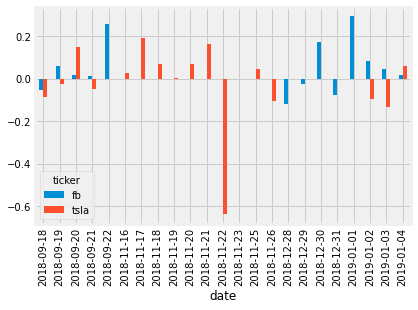

In [17]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

mean_c = scored_news.groupby(['date', 'ticker']).mean()
mean_c = mean_c.unstack(level=1)
mean_c = mean_c.xs('compound', axis=1)
mean_c.plot.bar()

### Duplicates ###
We can see that we have an outlier as the sentiment generated for TSLA was quite extreme on the 22nd of November. Taking a peak into the headlines on the day, we can see that there were only 5 headlines on that day and two headlines are esentially the same as another but from a different news source.

In [20]:

num_news_before = scored_news['headline'].count()
scored_news_clean = scored_news.drop_duplicates(subset=['ticker', 'headline'])
num_news_after = scored_news_clean['headline'].count()
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

### Finding sentiment for a single stock on a single day ###
To get a better understanding of the data and the dataset, producing a informative plot and very basic plot showing headline and subscores is needed.

In [ ]:

single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day = single_day.loc['fb']
single_day = single_day.loc['2019-01-03']
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time 
single_day = single_day.set_index('time')
single_day = single_day.sort_index(ascending=True)

### Visualising the single day ###
Making a plot to visualize the positive, negative and neutral scores for a single stock on a single trading day. 

In [ ]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]
plot_day = single_day.drop(['compound', 'headline'], 1)
plot_day.columns = ['negative', 'neutral', 'positive']
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");